In [1]:
## Uncomment the following lines if their respective packages are not yet installed:
# install.packages("GGally")   
# install.packages("caret")
# install.packages('e1071', dependencies=TRUE)

library(tidyverse)
library(caret)
library(ggplot2)
library(GGally)
library(repr)
library(purrr)
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘GGally’


The following object is masked from ‘package:dplyr’:

    nasa




# Predicting Tennis Match Winners

**Course:** DSCI 100 | Term 2 | 2019W

**Submitted by:**
* Jerry Hall
* Nic Tavares
* Jennifer Zhang
* Huy Pham

# 1 Introduction

The US Open grand slam tennis tournament has an estimated total prize money pool of USD $50.4 million. This puts it in line with high-value tournaments such as the MLB World Series and the PGA FedEx Cup. According to Sports Mechanics journal, height significantly affects players' serve speed, which in turn boost their odds of winning<sup>1</sup>. Another common claim is that the "prime" age ranges from 27 to 31 in which players perform at their very peak<sup>2</sup>. With such a high potential payoff, there is much incentive for competitive tennis athletes, coaches and potential sponsors to understand the player attributes that contribute to tournament success<sup>3</sup>.

The purpose of the study is to determine whether certain attributes contribute to greater competitive success by analyzing player and match information. This project will study the data of tennis match results collected for the top 500 tennis players from 2017-2019. Further, we will classify the attributes of interest and test whether the potential match outcome of a given player, within an acceptable margin of error, can be predicted. Finally, the results of this study will be used to verify the accuracy of hypothesis made by academic scholars.

We hope to find the answers to these questions by analyzing a comprehensive dataset contains results from nearly 7,000 matches of the top 500 tennis players in different tournaments. This dataset includes match lengths, winner and loser's dominant hands, ages, heights and their number of aces<sup>4</sup>. The selection of these attributes is based on the assumed low correlation between variables and the heated controversy surrounding their role in players' performance.



# 2 Methods


### 2.1 Method Selection

In this study, we are interested in classifying a categorical variable (wins and losses). K Nearest Neighbour (KNN) Classification is a non-parametric, lazy learning algorithm. Its purpose is to use a database in which the data points are separated into several classes to predict the classification of a new sample point. Therefore, we will use the KNN approach.

The other predictive methods taught in this course, KNN regression and linear regression, are used to predict numeric (quantitative) values. As we do not have a quantitative variable to predict, these techniques are not useful in answering the questions this research seeks to answer.

### 2.2 Dataset Loading

We will start by loading the dataset from an online repository. 

The tennis player data is available on Jeff Sackmann's GitHub<sup>4</sup> and is split into CSV files by year. To begin, we will use the `read_csv()` function to scrape the data from the web and use `rbind()` to combine the three dataframes into a single one.

In [2]:
data2017 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2017.csv', col_types = cols())
data2018 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2018.csv', col_types = cols())
data2019 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv', col_types = cols())

combined_data <- rbind(data2017, data2018, data2019)

### 2.3 Wrangling and Cleaning

Next, we select the columns that we are interested in and tidy the data based on whether the given match result was a win or loss.

In [3]:
tennis <- combined_data %>% 
    select(winner_hand, loser_hand, winner_age, loser_age, winner_ht, loser_ht, minutes, w_ace, l_ace)

tennis_win = select(tennis, winner_hand, winner_age, winner_ht, minutes, w_ace)
tennis_loss = select(tennis, loser_hand, loser_age, loser_ht, minutes, l_ace)

tennis_win = mutate(tennis_win, hand = winner_hand, age = winner_age, height = winner_ht, aces = w_ace, result = 'w') %>%
            select(-winner_hand, -winner_age, -winner_ht, -w_ace)
tennis_loss = mutate(tennis_loss, hand = loser_hand, age = loser_age, height = loser_ht, aces = l_ace, result = 'l') %>%
            select(-loser_hand, -loser_age, -loser_ht, -l_ace)

cleaned_data = rbind(tennis_win, tennis_loss)

The match result is then converted to a factor. This allows us to categorize each match winner and loser. The results of this categorization is shown below.

In [4]:
cleaned_data = mutate(cleaned_data, result = as.factor(result))
rows = sample(nrow(cleaned_data))
cleaned_data = cleaned_data[rows, ]

head(cleaned_data)

minutes,hand,age,height,aces,result
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
100,R,24.89802,NA,4,w
149,R,31.73169,198,22,w
62,R,27.03080,188,3,w
156,R,29.50308,178,3,l
65,R,33.11157,180,2,w
86,R,22.87748,NA,3,l


### 2.4 Splitting and Summarizing

Next, we separate the tidied data into a training_set and a testing_set. The training_set will be given 0.75 of the cleaned_data set; testing_set will be given 0.25. This is so that our model is trained against the training set and we can later perform cross-validation with a testing set to find an optimal k-value.

We will use the `createDataPartition()` function and the `slice()` function to split the data into two sets.

**Notes:** 

- We have opted to omit entries containing `NA` values. This is to prevent issues from occurring with our training model later on.   
- `createDataPartition()` uses random sampling to select rows. We have chosen to include `set.seed(42)` so that the results are reproducible for anyone who runs the .ipynb notebook.

In [5]:
set.seed(42)

training_rows <- cleaned_data %>%
    select(result) %>% 
    unlist() %>%
    createDataPartition (p = 0.75 , list = FALSE)

training_set <- cleaned_data %>% slice (training_rows) %>% na.omit()
testing_set <- cleaned_data %>% slice (-training_rows) %>% na.omit()
head(training_set)

minutes,hand,age,height,aces,result
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
149,R,31.73169,198,22,w
62,R,27.03080,188,3,w
156,R,29.50308,178,3,l
65,R,33.11157,180,2,w
103,R,34.90760,180,2,w
64,R,26.80082,163,6,w


### 2.5 Dataset Visualization

Now that the sets have been partitioned, we plot a matrix of the parameters that will later be used to perform analysis of predicted player match outcomes.

-----
The two goals that we want to achieve with our visualization are the following:

- The correlation between our predicting variables. If one variable is highly correlated to another, we may eliminate them and simplify the modelling process. We achieve this by using the `ggcorr()` function.
- The correlation between our predicting variables with our labeling variables. We achieve this by using the `ggpair()` function. While `ggcorr()` provides a straightforward matrix with results of correlation between variables, `ggpair()` gives us a comprehensive view of how each variable correlates to each other through histograms, box plots, regression model and more.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



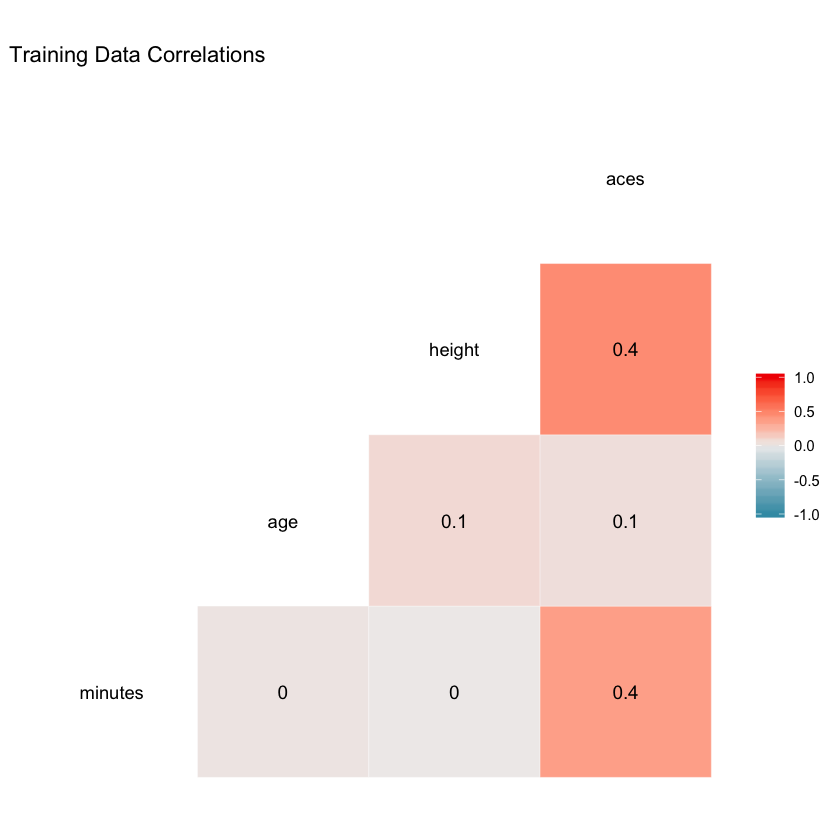

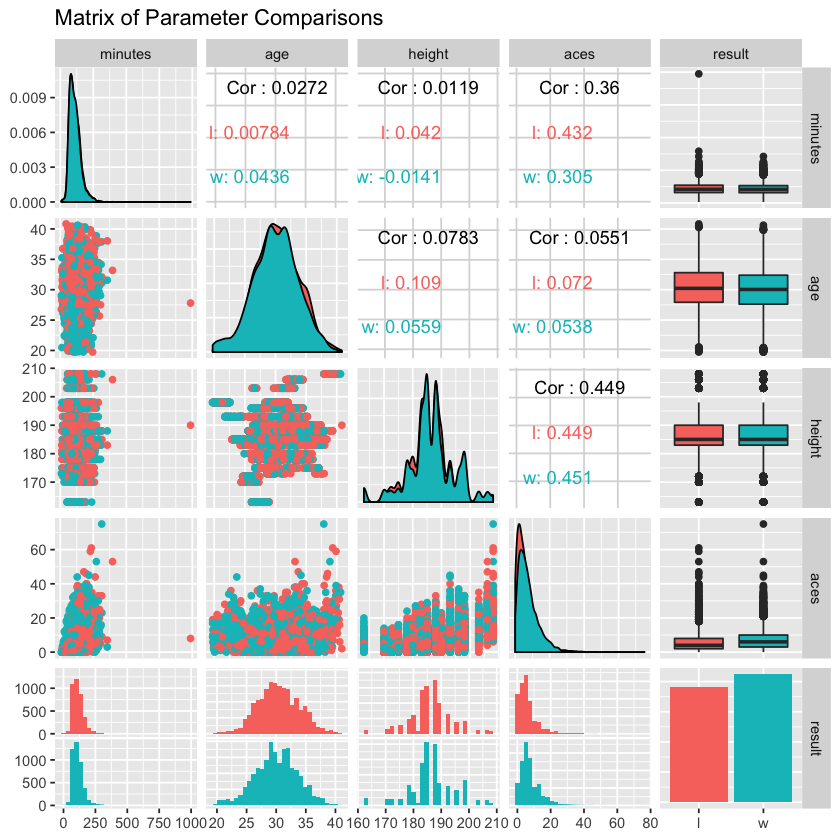

In [6]:
options (repr.plot.width=7, repr.plot.height=7)
tennis_matrix_train <- ggcorr(select(training_set, -hand, -result), label = TRUE,) + labs(title = "Training Data Correlations")
tennis_matrix_train

training_set2 = select(training_set, -hand)
tennis_train_pairs = ggpairs(training_set2, columns = 1:5, ggplot2::aes(colour=result), progress = FALSE,) + labs(title="Matrix of Parameter Comparisons")
tennis_train_pairs

An intersting observation to note from the **Matrix of Parameter Comparisons** above is that visually, the distributions of `Minutes`, `Age`, `Height`, and `Aces` do not appear to vary for each winning and losing `result`. We will keep this in mind when performing our analysis later.

Some additional comments about the observations above:
- There is an imbalance in the number of winners and losers. This is due to `NA` values being removed in *2.4 Splitting and Summarizing*. While this may influence our data ever so slightly as we will be training our KNN classification model with more observations of winners than losers, we will not account for the difference for the purposes of the experiment as the difference is small.
- There is little correlation between the various parameters as seen in the **Training Data Correlations** matrix.
- Upon visual inspection, there does not appear to be any obvious clustering in any of the scatterplots. 

### 2.6 Dataset Numerical Summaries

   
Next, we will create some basic tables so that we can observe the number of left-handed players vs. right-handed players and the summary statistics of each of the predictor variables we are using.

In the tables below, we will see that there are more right handed players, which is something to keep in mind later. 

In [7]:
training_table = group_by(training_set, hand) %>%
    summarize(count = n())
training_table

quantitative_summary_table <- training_set %>%
    select_if(is.numeric)  %>%
    map(~tidy(summary(.x))) %>%  
    do.call(rbind, .) %>%
    t()
quantitative_summary_table

hand,count
<chr>,<int>
L,1210
R,6847


,minutes,age,height,aces
minimum,8.0000,19.74264,163.0000,0.000000
q1,80.0000,27.76728,183.0000,3.000000
median,104.0000,30.12183,185.0000,5.000000
mean,111.1568,30.16658,186.3125,6.843366
q3,134.0000,32.51198,190.0000,9.000000
maximum,987.0000,40.82957,208.0000,75.000000


### 2.7 Classification Model Tuning  

In order to perform KNN classification, we first need to alter the `hand` column to be a numerical value instead of a categorical value. Then, we will need to scale our data so that no characteristics are overweight or underweight based on the unit in which they were measured. We have arbitrarily chosen `1` to represent right-handed players and `0` to represent left-handed players.

In [8]:
training_data_scaled = training_set %>% mutate(hand = ifelse(hand == "R", 1, 0))

training_data_scaled = training_data_scaled %>% 
                        mutate(minutes = scale(minutes, center = TRUE)) %>%
                        mutate(age = scale(age, center = TRUE)) %>%
                        mutate(height = scale(height, center = TRUE)) %>%
                        mutate(aces = scale(aces, center = TRUE))

testing_data_scaled = testing_set %>% mutate(hand = ifelse(hand == "R", 1, 0))

testing_data_scaled = testing_data_scaled %>% 
                        mutate(minutes = scale(minutes, center = TRUE)) %>%
                        mutate(age = scale(age, center = TRUE)) %>%
                        mutate(height = scale(height, center = TRUE)) %>%
                        mutate(aces = scale(aces, center = TRUE))



head(training_data_scaled)
head(testing_data_scaled)
                    

minutes,hand,age,height,aces,result
"<dbl[,1]>",<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
0.8699029,1,0.4353227,1.4969383,2.5143238,w
-1.1299668,1,-0.8721938,0.2161329,-0.6375734,w
1.0308120,1,-0.1845483,-1.0646724,-0.6375734,l
-1.0610058,1,0.8191249,-0.8085114,-0.8034627,w
-0.1874995,1,1.3186770,-0.8085114,-0.8034627,w
-1.0839928,1,-0.9361609,-2.9858805,-0.1399054,w


minutes,hand,age,height,aces,result
"<dbl[,1]>",<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
0.5823496,1,-0.07940148,0.2117896,-0.2959947,w
-1.1502099,1,-0.46791791,-1.0650304,-0.9449850,w
0.6813530,1,0.96820529,-0.4266204,-0.1337471,l
1.1021175,1,0.27519684,2.1270196,1.3264812,w
-0.7789471,0,-0.01310702,-0.4266204,0.5152433,w
-0.4324352,0,-0.52958718,0.4671536,0.1907481,w


Now we will split the data into:
* `X_train`
* `X_test`
* `Y_train`
* `Y_test`


In [9]:
X_train = training_data_scaled %>%
        select(-result) %>%
        data.frame()

Y_train = training_data_scaled %>%
        select(result) %>%
        unlist()

X_test = testing_data_scaled %>%
        select(-result) %>%
        data.frame()

Y_test = testing_data_scaled %>%
        select(result) %>%
        unlist()
            

Next, we will be using our training data to build a model. First thing we need to do is choose a number k that represents the number of neighbors we will be examining in order to determine the classification of a new data point. We will be evaluating k in the range of 1:50 and using 10-fold cross validation.

**Note:** We have chosen to include `set.seed(42)` so that the results below are reproducible for anyone who runs this .ipynb notebook in the future.

In [23]:
set.seed(42)
ks = data.frame(k = c(1:50))
train_control <- trainControl(method = "cv", number = 10)
choose_k = train(x = X_train, y = Y_train, method = "knn", tuneGrid = ks, trControl = train_control)
choose_k


k-Nearest Neighbors 

8057 samples
   5 predictor
   2 classes: 'l', 'w' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7252, 7251, 7252, 7251, 7251, 7252, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa     
   1  0.5402793  0.07775677
   2  0.5444976  0.08599670
   3  0.5528148  0.10138823
   4  0.5539322  0.10428070
   5  0.5634875  0.12222401
   6  0.5654657  0.12636043
   7  0.5689421  0.13241960
   8  0.5659650  0.12684882
   9  0.5719244  0.13869122
  10  0.5765163  0.14793435
  11  0.5725454  0.13958298
  12  0.5780063  0.15061784
  13  0.5791216  0.15309646
  14  0.5786289  0.15217754
  15  0.5864462  0.16789290
  16  0.5809872  0.15686843
  17  0.5853284  0.16577732
  18  0.5849580  0.16506058
  19  0.5847072  0.16436414
  20  0.5853302  0.16520548
  21  0.5879344  0.17088980
  22  0.5838414  0.16264455
  23  0.5859507  0.16717598
  24  0.5840874  0.16339661
  25  0.5829701  0.16142931
  26  0.5871874  0.16986747


Now, we will plot the accuracies for our various k values and visually determine the value of `k` for which the maximum accuracy is achieved.

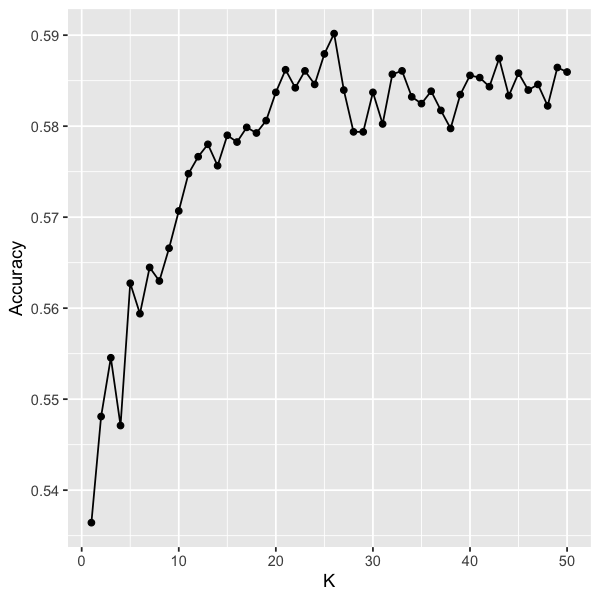

In [18]:
k_accuracies_again <- choose_k$results %>% select(k, Accuracy)
options(repr.plot.width=5, repr.plot.height=5)
choose_k_again_plot <- ggplot(k_accuracies_again, aes(x = k, y = Accuracy)) +
                          geom_line() +
                          geom_point() +
                            labs(x = "K", y = "Accuracy")


# your code here
choose_k_again_plot

As seen in the plot above, `k = 21` gives us the highest accuracy out of the values we tested. 

**Select `k = 21` for our model.**

### 2.8 Classification Model Evaluation

We will retrain our model and assign the trained model to `final_classifier`.

In [20]:
set.seed(42)
final_k = data.frame(k = 20)
final_classifier <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = final_k)
# final_classifier

Now, we can test the accuracy of our model using the testing set data that we split off earlier.

In [21]:
test_pred <- predict(final_classifier, X_test)
test_results <- confusionMatrix(test_pred, Y_test)
test_results$overall[1]
test_results

Accuracy 
0.5854112

Confusion Matrix and Statistics

          Reference
Prediction   l   w
         l 663 525
         w 589 910
                                          
               Accuracy : 0.5854          
                 95% CI : (0.5665, 0.6041)
    No Information Rate : 0.5341          
    P-Value [Acc > NIR] : 4.8e-08         
                                          
                  Kappa : 0.1642          
                                          
 Mcnemar's Test P-Value : 0.05909         
                                          
            Sensitivity : 0.5296          
            Specificity : 0.6341          
         Pos Pred Value : 0.5581          
         Neg Pred Value : 0.6071          
             Prevalence : 0.4659          
         Detection Rate : 0.2467          
   Detection Prevalence : 0.4421          
      Balanced Accuracy : 0.5818          
                                          
       'Positive' Class : l               
                              

From the confusion matrix generated above, we will note the following observations:
- The accuracy of our KNN classification model when tested against our test set is `58.54%`. This is quite a low value. 
- The 95% confidence interval is: $CI \in [0.5665, 0.6041]$. The confidence interval describes the range in which we are 95% *confident* that the true accuracy lies. In plain words, this means it is highly unlikely that the true accuracy of our model exceeds `60%`.

# 3 Discussion

### 3.1 Summary

The success rate of our classification model at predicting the match outcome from our training data was `58.54%`. This accuracy is only marginally higher than a coin flip (ie. 50% chance) and is not significant enough such that we can recommend its use for predicting successful matches. 

We were also interested in determining whether certain attributes contributed towards greater match success. As we saw in the Matrix of Parameter Comparisons in *2.4 Dataset Visualization*, there was no significant correlation between the parameters `Minutes`, `Age`, `Height`, `Aces` with the actual `Result`. This is further augmented by the low accuracy of the classification model seen in *2.6 Classification Model Evaluation*.

The results observed from the classification model and the correlation matrix suggests that the `Minutes`, `Age`, `Height` and `Aces` parameters are not effective predictors of tennis match success. 

### 3.2 Expectations

In the initial stages of our project, we hypothesized that certain attributes would contribute to greater or lesser tennis match success. As mentioned in the *Introduction*, age can be a key variable that determined success. For instance, it was conceivable that younger players perform better than older players; therefore, age correlates inversely with match success. 

From analyzing the quantitative player and match data, we expected to predict the outcome of any future tennis match with a high degree of accuracy.

Given the discovery that our model only performs slightly better than a coin flip (as seen in **(figure x)**), and more specifically, the distributions of ages of winners and losers are nearly identical (as seen in figure y), the results of our test show that there is no strong correlation between any of our test parameters and match success.

### 3.3 Significance and Future Research

If our original expectations of this research had turned out to be correct it could have been an extremely useful tool for coaches to evaluate the prospects of up and coming players as well as companies looking to get early and high value sponsorships with up and coming players. However, it seems like predicting tennis match outcomes, if possible at all, will require much more in depth analysis of variables. Future research might take into account more quantitative variables such as play style and pair them with the variables that were used in this research to examine the ways that players' playstyles change based on the various physical attributes of the player and further examine how these things affect tennis match results.

The result of our findings clearly suggests that `Minutes`, `Age`, `Height`, `Aces` alone cannot predict the outcome of a given match. If our original expectations of this research had turned out to be correct, it potentially could have been a useful tool for coaches to evaluate the prospects of new players as well as companies looking to get early and high value sponsorships with up and coming players.

However, it is important to note that these results do not disqualify the influence of these characteristics in individual matches. This experiment looked at whether the given parameters alone had overall predictive validity and did not examine them at the individual match level. For example, rather than asking, "do winners of tennis matches tend to be younger?", a future experiment could ask, "do younger tennis players have a higher tendency of winning against older players?"

The above context could be summarized in the following sentence: **"player characteristics alone cannot predict the probability of overall match success; however, they may have the potential to influence the success of the individual match depending on the characteristics of the opponent."**

This opens the door to future research whereby individual matches can be analyzed for the quantitative differences between the winner and loser. An example of this research could be, "do left-handed players have a higher probability of defeating right-handed opponents than left-handed opponents?" or "does the age difference between match opponents influence the outcome?"

Finally, future research might also consider additional quantitative variables, such as play style, and pair them with the variables that were used in this research to examine the ways it interacts with the various physical attributes of the player and how they affect tennis match results.

# References

<sup>1</sup> Vaverka, Frantisek & Cernosek, Miroslav (2013). Association between body height and serve speed in elite tennis players. Sports Biomech, 12, 30-7, DOI: 10.1080/14763141.2012.670664. 

<sup>2</sup> César Gallo-Salazar, Juan José Salinero, David Sanz, Francisco Areces & Juan del Coso (2015). Professional tennis is getting older: Age for the top 100 ranked tennis players. International Journal of Performance Analysis in Sport, 15:3, 873-883, DOI: 10.1080/24748668.2015.11868837

<sup>3</sup> 10 Sporting events with the most prize money. (2017, September 10). PledgeSports. Retrieved from: https://www.pledgesports.org/2017/09/10-sporting-events-with-the-biggest-prize-money/

<sup>4</sup> Slackman, J. (2020, January 30). JeffSackmann/tennis_atp. Retrieved from https://github.com/JeffSackmann/tennis_atp